# Analysis of ProGen2 Candidates with AI4AMP and ESMFold

This notebook loads `candidates_scored_and_folded.csv`, ranks candidates by antimicrobial probability and structural confidence, and produces basic plots and summary tables.

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [96]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120

csv_path = "candidates_scored_and_folded.csv"
df = pd.read_csv(csv_path)
print("Loaded dataframe with shape:", df.shape)
print(df.columns)

# Combined score
df["combined_score"] = (
    0.333 * df["ai4amp_score"]
    + 0.333 * df["pLDDT_mean"]
    + 0.333 * df["PAE_mean"]
) / 100.0

Loaded dataframe with shape: (784, 6)
Index(['id', 'seq', 'ai4amp_score', 'pLDDT_mean', 'PAE_mean', 'pdb_path'], dtype='object')


In [97]:
# 1. Select top N by AI4AMP score
TOP_N = 10
df_top = df.sort_values("ai4amp_score", ascending=False).head(TOP_N)

print(f"Top {TOP_N} by AI4AMP score:")
display(df_top[["id", "seq", "ai4amp_score", "pLDDT_mean", "PAE_mean", "combined_score"]])

Top 10 by AI4AMP score:


,id,seq,ai4amp_score,pLDDT_mean,PAE_mean,combined_score
329,cand_330,MRSAVQQGSKGYADDFGGLTALVVSAGQAAYAYLGRRL,0.462298,0.580517,11.836327,0.042888
145,cand_146,MRSALRSATSHFEWNFGGIILWRRAYRRRKA,0.460811,0.524628,12.485670,0.044859
730,cand_731,MRSAVPRLTATIENLIHAVSSVWSRVGRYA,0.460505,0.717101,4.949295,0.020403
139,cand_140,MRSASVVCSFGREAIGAVRRLGFLGRALLHQ,0.460427,0.676199,6.664416,0.025977
374,cand_375,MRSAARCANFLNFVGGGAWLFKRYL,0.460337,0.603948,7.682661,0.029127
314,cand_315,MRSASLLSTWIGAATISFAHAVLAIGGYLGYGR,0.460334,0.680343,6.385505,0.025062
90,cand_91,MRSAAASRRKRWLNNAIRHLWGGVGYRGEVAS,0.460309,0.566841,10.304627,0.037735
300,cand_301,MRSAAETAGQVQEEYNAATARTNLFTSNGRRAALKAYRR,0.460176,0.624348,10.690890,0.039212
534,cand_535,MRSASANASAGAIAALGRTTSAVIGGGTAYYWYRR,0.460041,0.490396,17.941149,0.062909
208,cand_209,MRSAAAPSHRALHHSGKLWVKPLAILLIAAAALLLK,0.459967,0.610794,12.555820,0.045377


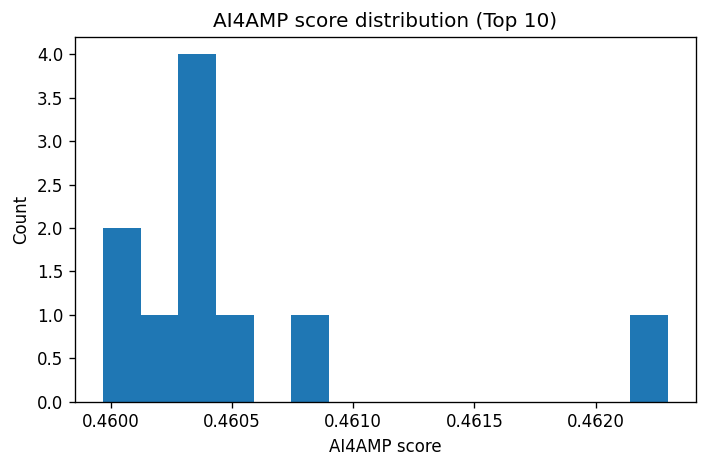

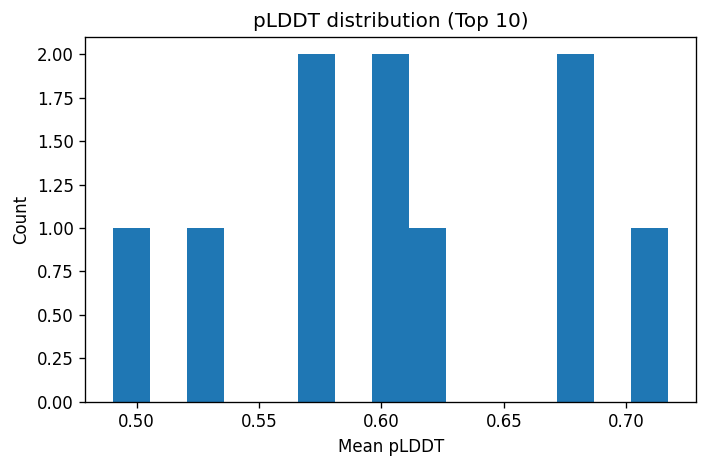

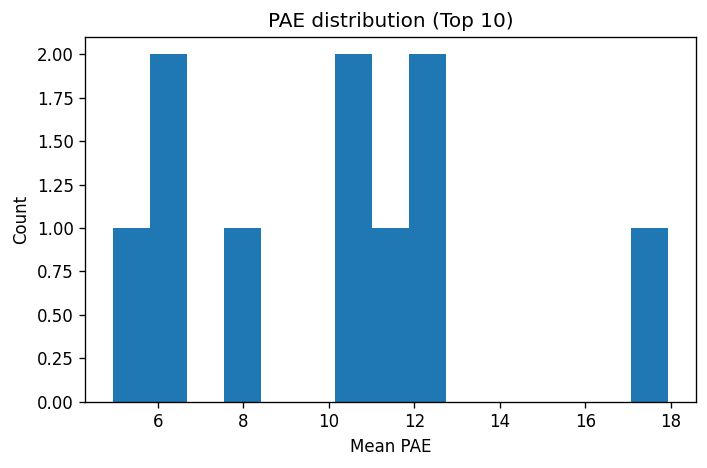

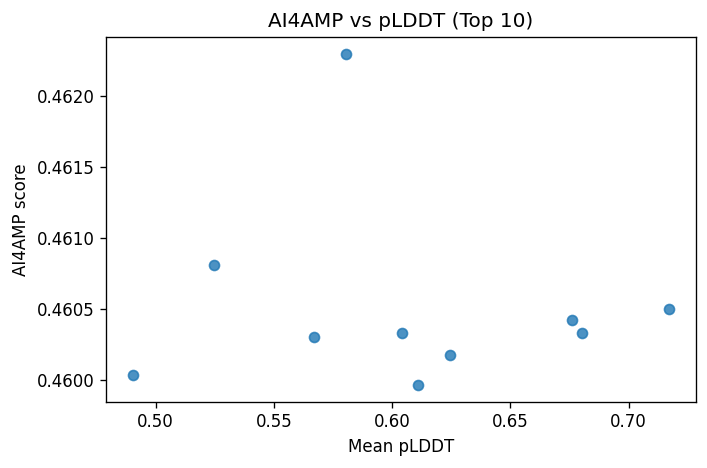

In [98]:
# 2. Plots using ONLY top N candidates
# AI4AMP distribution
plt.hist(df_top["ai4amp_score"], bins=15)
plt.xlabel("AI4AMP score")
plt.ylabel("Count")
plt.title(f"AI4AMP score distribution (Top {TOP_N})")
plt.tight_layout()
plt.show()

# pLDDT distribution
plt.hist(df_top["pLDDT_mean"], bins=15)
plt.xlabel("Mean pLDDT")
plt.ylabel("Count")
plt.title(f"pLDDT distribution (Top {TOP_N})")
plt.tight_layout()
plt.show()

# PAE distribution
plt.hist(df_top["PAE_mean"], bins=15)
plt.xlabel("Mean PAE")
plt.ylabel("Count")
plt.title(f"PAE distribution (Top {TOP_N})")
plt.tight_layout()
plt.show()

# Scatter: pLDDT vs AI4AMP
plt.scatter(df_top["pLDDT_mean"], df_top["ai4amp_score"], alpha=0.8)
plt.xlabel("Mean pLDDT")
plt.ylabel("AI4AMP score")
plt.title(f"AI4AMP vs pLDDT (Top {TOP_N})")
plt.tight_layout()
plt.show()

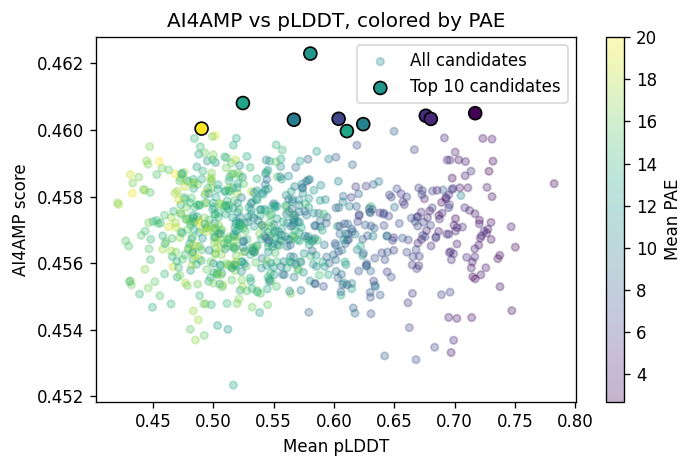

In [99]:
fig, ax = plt.subplots()

# All candidates (colored by PAE so we get a mappable)
sc_all = ax.scatter(
    df["pLDDT_mean"],
    df["ai4amp_score"],
    c=df["PAE_mean"],
    cmap="viridis",
    alpha=0.3,
    s=20,
    label="All candidates"
)

# Top N highlighted (use same cmap)
ax.scatter(
    df_top["pLDDT_mean"],
    df_top["ai4amp_score"],
    c=df_top["PAE_mean"],
    cmap="viridis",
    edgecolor="black",
    s=60,
    label=f"Top {TOP_N} candidates"
)

# Create colorbar USING sc_all as the mappable
cb = plt.colorbar(sc_all)
cb.set_label("Mean PAE")

ax.set_xlabel("Mean pLDDT")
ax.set_ylabel("AI4AMP score")
ax.set_title("AI4AMP vs pLDDT, colored by PAE")
ax.legend()
plt.tight_layout()
plt.show()

In [100]:
# Sort by AI4AMP and assign ranks
df_top = df.sort_values("ai4amp_score", ascending=False).head(TOP_N).copy()
df_top["rank"] = np.arange(1, TOP_N + 1)

# Extract values
ai4amp_vals = df_top["ai4amp_score"].values
plddt_vals  = df_top["pLDDT_mean"].values
pae_vals    = df_top["PAE_mean"].values

# Compute means and std
ai4amp_mean, ai4amp_std = ai4amp_vals.mean(), ai4amp_vals.std(ddof=1)
plddt_mean,  plddt_std  = plddt_vals.mean(),  plddt_vals.std(ddof=1)
pae_mean,    pae_std    = pae_vals.mean(),    pae_vals.std(ddof=1)

# Add the "Mean" group as (N+1)th entry
ai4amp_all = np.append(ai4amp_vals, ai4amp_mean)
plddt_all  = np.append(plddt_vals,  plddt_mean)
pae_all    = np.append(pae_vals,    pae_mean)

num_groups = TOP_N + 1
x = np.arange(num_groups)
bar_width = 0.33

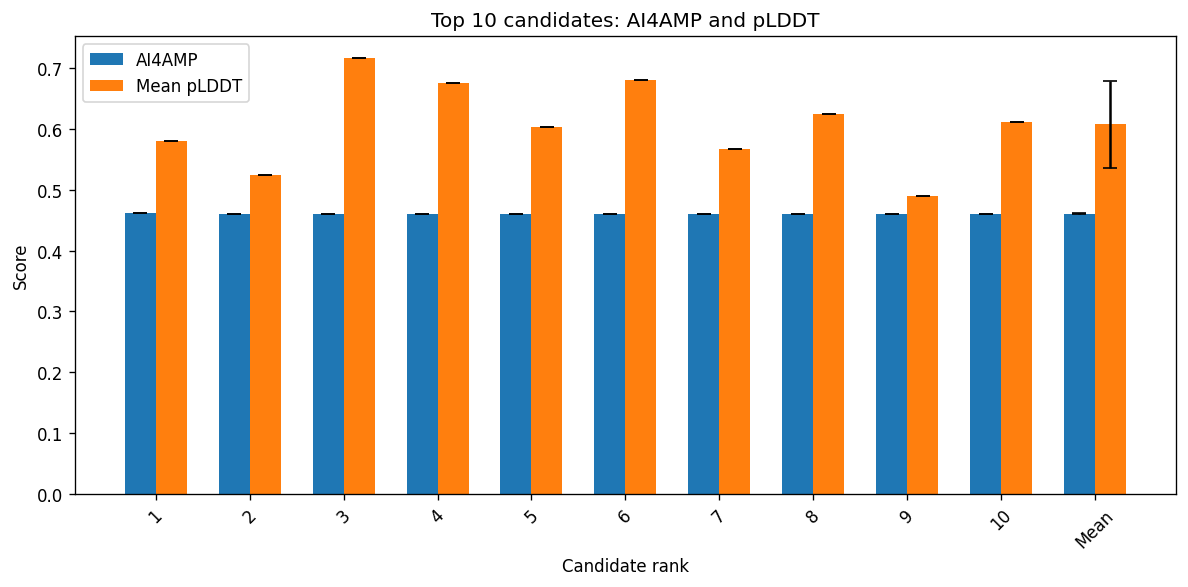

In [101]:
fig, ax = plt.subplots(figsize=(10, 5))

# Error bars only on the "Mean" group
ai4amp_err = np.zeros(num_groups)
plddt_err  = np.zeros(num_groups)
ai4amp_err[-1] = ai4amp_std
plddt_err[-1]  = plddt_std

ax.bar(x - bar_width/2, ai4amp_all, width=bar_width, yerr=ai4amp_err,
       capsize=4, label="AI4AMP")

ax.bar(x + bar_width/2, plddt_all, width=bar_width, yerr=plddt_err,
       capsize=4, label="Mean pLDDT")

# Labels
xtick_labels = [str(r) for r in df_top["rank"]] + ["Mean"]
ax.set_xticks(x)
ax.set_xticklabels(xtick_labels, rotation=45)

ax.set_ylabel("Score")
ax.set_xlabel("Candidate rank")
ax.set_title(f"Top {TOP_N} candidates: AI4AMP and pLDDT")
ax.legend()
plt.tight_layout()
plt.show()

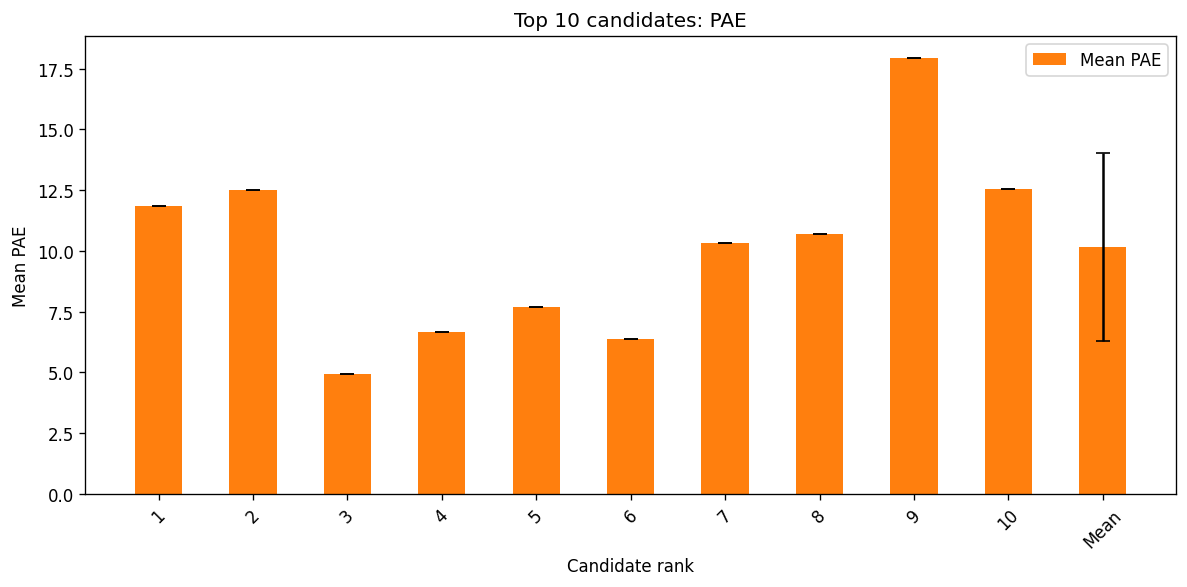

In [102]:
fig, ax = plt.subplots(figsize=(10, 5))

pae_err = np.zeros(num_groups)
pae_err[-1] = pae_std

ax.bar(x, pae_all, width=0.5, yerr=pae_err,
       capsize=4, color="tab:orange", label="Mean PAE")

xtick_labels = [str(r) for r in df_top["rank"]] + ["Mean"]
ax.set_xticks(x)
ax.set_xticklabels(xtick_labels, rotation=45)

ax.set_ylabel("Mean PAE")
ax.set_xlabel("Candidate rank")
ax.set_title(f"Top {TOP_N} candidates: PAE")
ax.legend()
plt.tight_layout()
plt.show()

In [103]:
cols = ["id", "seq", "ai4amp_score", "pLDDT_mean", "PAE_mean"]
df_top[cols].head(TOP_N)

,id,seq,ai4amp_score,pLDDT_mean,PAE_mean
329,cand_330,MRSAVQQGSKGYADDFGGLTALVVSAGQAAYAYLGRRL,0.462298,0.580517,11.836327
145,cand_146,MRSALRSATSHFEWNFGGIILWRRAYRRRKA,0.460811,0.524628,12.485670
730,cand_731,MRSAVPRLTATIENLIHAVSSVWSRVGRYA,0.460505,0.717101,4.949295
139,cand_140,MRSASVVCSFGREAIGAVRRLGFLGRALLHQ,0.460427,0.676199,6.664416
374,cand_375,MRSAARCANFLNFVGGGAWLFKRYL,0.460337,0.603948,7.682661
314,cand_315,MRSASLLSTWIGAATISFAHAVLAIGGYLGYGR,0.460334,0.680343,6.385505
90,cand_91,MRSAAASRRKRWLNNAIRHLWGGVGYRGEVAS,0.460309,0.566841,10.304627
300,cand_301,MRSAAETAGQVQEEYNAATARTNLFTSNGRRAALKAYRR,0.460176,0.624348,10.690890
534,cand_535,MRSASANASAGAIAALGRTTSAVIGGGTAYYWYRR,0.460041,0.490396,17.941149
208,cand_209,MRSAAAPSHRALHHSGKLWVKPLAILLIAAAALLLK,0.459967,0.610794,12.555820
